In [ ]:
# Global inversion with empymod

#%matplotlib notebook

# Code for Global Inversion 

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed

Creating a synthetic model

In [2]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
dip = np.array([0, 90])

Hreceivers = [offsets, offsets*0, 0, 0, 0]
Vreceivers = [offsets, offsets*0, 0, 0, 90]
Preceivers = [offsets, offsets*0, 0, 90, 90]

# Source geometry

Hsource = [0, 0, 0 ,0 , 0]
Vsource = [0, 0, 0, 0, 90]

# Frequency

freq = 9000

In [3]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

resistivities = [10,50,10]
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50

In [4]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=1, vmax=100)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

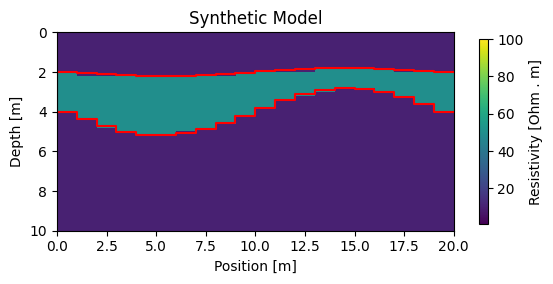

In [5]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')

Define forward model function

In [6]:
def EMforward(x):
    # x is input model
    surface = np.array([0])
    thkx = np.array(x[0:2])
    depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
    res_ground = np.array(x[2:])
    res_air = np.array([2e14])
    resx = np.hstack((res_air, res_ground))
    HCP = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP = empymod.loop(Hsource, Preceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    Z = np.hstack((HCP, VCP, PRP))
    return Z

Load solutions hypercube

In [7]:
Responses_0to11 = np.load('Results_is1_0to11.npy')
Responses_11to21 = np.load('Results_is1_11to21.npy')


In [8]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data.append(EMforward(model_i)) # creating data

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [9]:
nsl = 21 # sampling number of the cube

s0 = -2 # minimum conductivity in S/m
s1 = -0.8 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

th0 = 0.1 # minimum thickness in m
th1 = 5   # maximum thickness in m
# thickness array
thicks = np.linspace(th0, th1, nsl)

In [10]:
def gridsearch(Zdata):    
    err = 1
    for i in range(len(Responses_0to11)):
        Z = Responses_0to11[i]
        nZdiff = np.abs(Z - Zdata) **2 / np.abs(Zdata)**2
        #merr = np.log10(np.sqrt(np.sum(nZdiff)))
        merr = np.sum(nZdiff)

        if merr < err: 
            err = merr
            ind = i
    for i in range(len(Responses_11to21)):
        Z = Responses_11to21[i]
        nZdiff = np.abs(Z - Zdata) **2 / np.abs(Zdata)**2
        #merr = np.log10(np.sqrt(np.sum(nZdiff)))
        merr = np.sum(nZdiff)

        if merr < err: 
            err = merr
            ind = len(Responses_0to11) + i
    #print('ind is:', ind)
    return ind

In [11]:
def search_model(ind):
    
    for is1 in range(nsl):
        for is2 in range(nsl):
            for is3 in range(nsl):
                for il1 in range(nsl):
                    for il2 in range(nsl):
                        i = il2+(il1)*nsl+(is3)*nsl**2+(is2)*nsl**3+(is1)*nsl**4
                        if i == ind:
                            #print('Found model')
                            model = [thicks[il1], thicks[il2], 1/conds[is1], 1/conds[is2], 1/conds[is3]]
                            return model              
                    

In [12]:
# Start inversion

startTime = time.time()

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    
    grid_i = gridsearch(dataE)

    model_est = search_model(grid_i)
    
    model_est_list.append(model_est)
    
    print('Estimated position ', i)

# Model estimation array    
model_est_arr = np.array(model_est_list)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

ind is: 3433744
Found model
Estimated position  0
ind is: 3433748
Found model
Estimated position  1
ind is: 3433751
Found model
Estimated position  2
ind is: 3424509
Found model
Estimated position  3
ind is: 3424510
Found model
Estimated position  4
ind is: 3424510
Found model
Estimated position  5
ind is: 3424509
Found model
Estimated position  6
ind is: 3424508
Found model
Estimated position  7
ind is: 3433750
Found model
Estimated position  8
ind is: 3433746
Found model
Estimated position  9
ind is: 3442989
Found model
Estimated position  10
ind is: 3443430
Found model
Estimated position  11
ind is: 3443426
Found model
Estimated position  12
ind is: 3452672
Found model
Estimated position  13
ind is: 3452651
Found model
Estimated position  14
ind is: 3452672
Found model
Estimated position  15
ind is: 3452210
Found model
Estimated position  16
ind is: 3443428
Found model
Estimated position  17
ind is: 3443432
Found model
Estimated position  18
ind is: 3433744
Found model
Estimated pos

<Figure size 640x480 with 0 Axes>

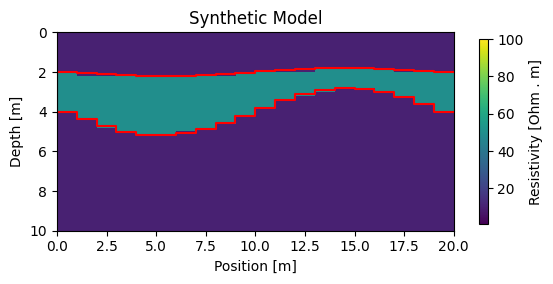

<Figure size 640x480 with 0 Axes>

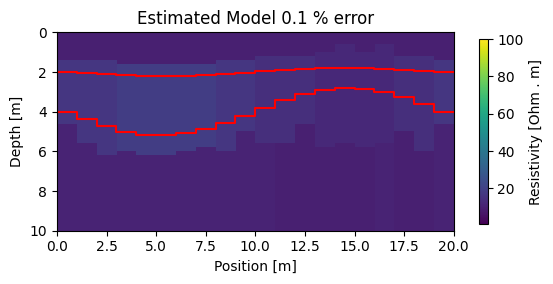

In [14]:
#Plot synthetic model
plt.figure()
depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')

# Plot estimated model
plt.figure()
depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')